# Case Study: Compositional Inference for a Drift Diffusion Model

Consider a decision task in which participants are presented with sequences of letters and asked
to differentiate between words and non-words (i.e., a lexical decision task). The Diffusion Decision Model (DDM;
e.g., Ratcliff et al., 2016) simulataneously models this binary decision and the response time via a continuous evidence
accumulation process: After an initial non-decision time t0, evidence accumulates following a noisy diffusion process
with a certain drift rate ν, starting from a point β, until one of two decision thresholds {0,α}corresponding to the two
choices is hit.

\begin{align*}
\mu_\nu \sim\mathcal{N}(0.5,0.3) \\
\mu_\alpha \sim\mathcal{N}(0,0.05) \\
\mu_{t_0}\sim \mathcal{N}(−1,0.3) \\
\log \sigma_\nu \sim\mathcal{N}(−1,1) \\
\log \sigma_\alpha \sim\mathcal{N}(−3,1) \\
\log \sigma_{t_0}\sim\mathcal{N}(−1,0.3) \\
\nu_j\sim\mathcal{N}(\mu_\nu,\sigma_\nu) \\
\log \alpha_j\sim\mathcal{N}(\mu_\alpha,\sigma_\alpha) \\
\log t_{0,j}\sim\mathcal{N}(\mu_{t_0} ,\sigma_{t_0} ) \\
\beta\sim\operatorname{Beta}(a=50,b=50) \\
y_j\sim \operatorname{DDM}(\nu_j,\alpha_j,t_{0,j},\beta)
\end{align*}

$\beta_\text{raw}$ is a transformed unbounded variable that is transformed to $\beta$ via the beta inverse CDF.

In [1]:
import os
if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "torch"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

import numpy as np
import matplotlib.pyplot as plt
import pickle

import keras
import bayesflow as bf

from ddm_simulator import simulate_ddm, beta_from_normal

problem_name = "compositional_case_study"
storage = '' #f'plots/{problem_name}/'
n_jobs = 10 #int(os.environ.get('SLURM_CPUS_PER_TASK', 1))

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [2]:
param_names_global = ['mu_nu', 'mu_log_alpha', 'mu_log_t0',
                      'log_sigma_nu', 'log_sigma_log_alpha', 'log_sigma_log_t0',
                      'beta_raw']
pretty_param_names_global = [r'$\mu_\nu$', r'$\mu_{\log \alpha}$', r'$\mu_{\log t_0}$',
                              r'$\log \sigma_\nu$', r'$\log \sigma_{\log \alpha}$', r'$\log \sigma_{\log t_0}$',
                              r'$\beta_\text{raw}$']
param_names_local = ['nu', 'alpha', 't0']
pretty_param_names_local = [r'$\nu_j$', r'$\alpha_j$', r'$t_{0,j}$']
num_training_batches = 256
num_validation_sets = 300
batch_size = 64
epochs = 1000

In [3]:
# ---------------------------
# Priors
# ---------------------------
n_trials = 25
def sample_priors(n_subjects=1):
    """
    Hierarchical draws as in your specification.
    Returns a dict with group params and per subject params.
    """
    # Group level
    mu_nu = np.random.normal(0.5, 0.3)
    mu_log_alpha = np.random.normal(0.0, 0.05)
    mu_log_t0 = np.random.normal(-1.0, 0.3)

    log_sigma_nu = np.random.normal(-1.0, 1.0)
    log_sigma_log_alpha = np.random.normal(-3.0, 1.0)
    log_sigma_log_t0 = np.random.normal(-1.0, 0.3)

    sigma_nu = np.exp(log_sigma_nu)
    sigma_log_alpha = np.exp(log_sigma_log_alpha)
    sigma_log_t0 = np.exp(log_sigma_log_t0)

    beta_raw = np.random.normal(0.0, 1.0)
    beta = beta_from_normal(beta_raw, a=50, b=50)

    # Subject level
    nu = np.random.normal(mu_nu, sigma_nu, size=n_subjects)
    log_alpha = np.random.normal(mu_log_alpha, sigma_log_alpha, size=n_subjects)
    log_t0 = np.random.normal(mu_log_t0, sigma_log_t0, size=n_subjects)
    alpha = np.exp(log_alpha)
    t0 = np.exp(log_t0)

    return {
        # group
        "mu_nu": mu_nu,
        "mu_log_alpha": mu_log_alpha,
        "mu_log_t0": mu_log_t0,
        "log_sigma_nu": log_sigma_nu,
        "log_sigma_log_alpha": log_sigma_log_alpha,
        "log_sigma_log_t0": log_sigma_log_t0,
        "beta_raw": beta_raw,
        "beta": beta,
        # subjects
        "nu": nu,
        "alpha": alpha,
        "t0": t0,
        # meta
        "n_subjects": n_subjects,
        "n_trials": n_trials,
    }


def score_log_norm(x, m, s):
    return -(x-m) / s**2

def prior_score(x: dict):
    mu_nu = x["mu_nu"]
    mu_log_alpha = x["mu_log_alpha"]
    mu_log_t0 = x["mu_log_t0"]
    log_sigma_nu = x["log_sigma_nu"]
    log_sigma_log_alpha = x["log_sigma_log_alpha"]
    log_sigma_log_t0 = x["log_sigma_log_t0"]
    beta_raw = x["beta_raw"]

    parts = {
        "mu_nu": score_log_norm(mu_nu, m=0.5, s=0.3),
        "mu_log_alpha": score_log_norm(mu_log_alpha, m=0.0, s=0.05),
        "mu_log_t0": score_log_norm(mu_log_t0, m=-1.0, s=0.3),
        "log_sigma_nu": score_log_norm(log_sigma_nu, m=-1.0, s=1.0),
        "log_sigma_log_alpha": score_log_norm(log_sigma_log_alpha, m=-3.0, s=1.0),
        "log_sigma_log_t0": score_log_norm(log_sigma_log_t0, m=-1.0, s=0.3),
        "beta_raw": score_log_norm(beta_raw, m=0.0, s=1.0),
    }
    return parts

simulator = bf.make_simulator([sample_priors, simulate_ddm])
print(simulator.sample(1)['sim_data'].shape)

(1, 25, 2)


In [4]:
if os.path.exists(f"{storage}validation_data_partial_pooling.pkl"):
    with open(f'{storage}validation_data_partial_pooling.pkl', 'rb') as f:
        validation_data = pickle.load(f)
    try:
        with open(f'{storage}training_data_partial_pooling.pkl', 'rb') as f:
            training_data = pickle.load(f)
    except FileNotFoundError:
        training_data = None
        print("Training data not found")
else:
    training_data = simulator.sample_parallel((num_training_batches * batch_size))
    validation_data = simulator.sample_parallel(num_validation_sets)

    with open(f'{storage}training_data_partial_pooling.pkl', 'wb') as f:
        pickle.dump(training_data, f)
    with open(f'{storage}validation_data_partial_pooling.pkl', 'wb') as f:
        pickle.dump(validation_data, f)

In [5]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .concatenate(param_names_global, into="inference_variables")
    .rename("sim_data", "summary_variables")
)

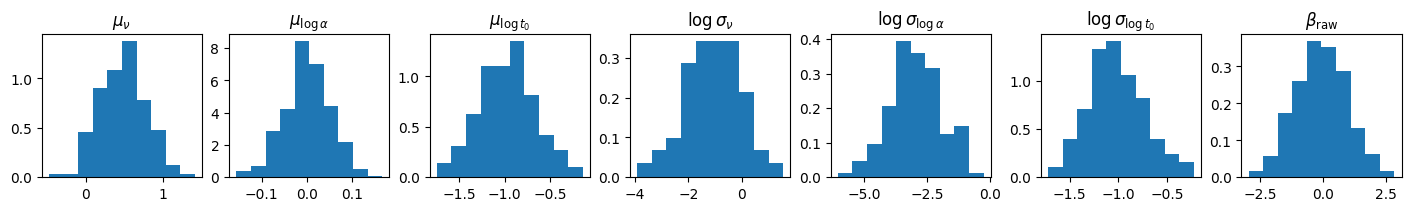

In [6]:
# check how the distributions look like
test_params = adapter.forward(validation_data)['inference_variables']

n_rows = len(param_names_global) // 4
n_cols = int(np.ceil(len(param_names_global) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows), layout='constrained')
ax = ax.flatten()
for i, name in enumerate(pretty_param_names_global):
    samples = test_params[:, i]
    ax[i].hist(samples, density=True)
    ax[i].set_title(name)
plt.show()

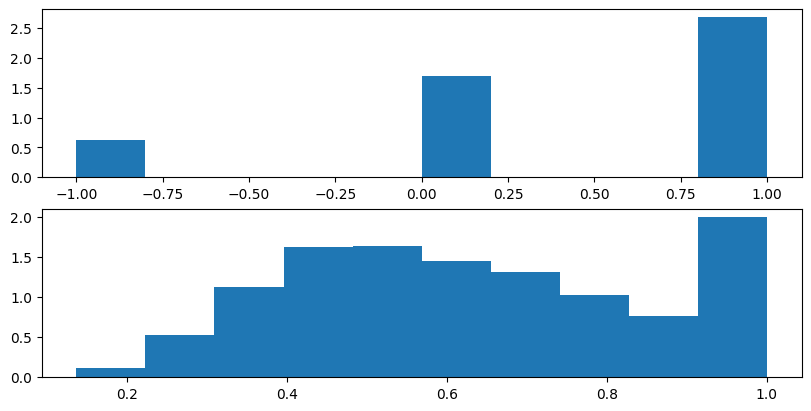

(300, 25, 2)


In [7]:
# check how the data distribution looks like (disable nan_to_num in adapter to see nans)
test_data = adapter.forward(validation_data)['summary_variables']
n_features = test_data.shape[-1]

fig, ax = plt.subplots(nrows=2, ncols=int(np.ceil(n_features / 2)), figsize=(8, 4), layout='constrained')
ax = ax.flatten()
for i in range(n_features):
    ax[i].hist(test_data[..., i].flatten(), density=True)
plt.show()

print(test_data.shape)

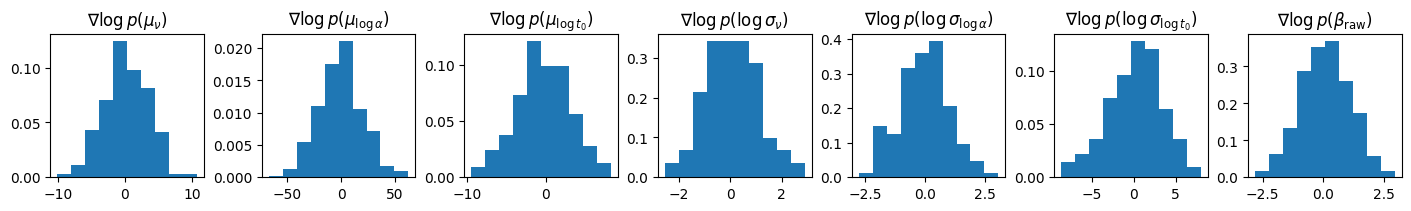

In [8]:
scores = prior_score(validation_data)

# check how the distributions look like
n_rows = len(param_names_global) // 4
n_cols = int(np.ceil(len(param_names_global) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows), layout='constrained')
ax = ax.flatten()
for i, name in enumerate(param_names_global):
    ax[i].hist(scores[name], density=True)
    ax[i].set_title(r'$\nabla \log p($' + pretty_param_names_global[i] + '$)$')
plt.show()

# Non-Compositional inference

In [9]:
workflow_global = bf.BasicWorkflow(
    adapter=adapter,
    summary_network=bf.networks.SetTransformer(summary_dim=16, dropout=0.1),
    inference_network=bf.networks.DiffusionModel(),
)

In [10]:
model_path = f'{storage}partial_pooling_global.keras'
if not os.path.exists(model_path):
    history = workflow_global.fit_offline(
        training_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=2,
    )
    workflow_global.approximator.save(model_path)
else:
    workflow_global.approximator = keras.models.load_model(model_path)

In [11]:
workflow_global.approximator.inference_network.integrate_kwargs = {'method': 'euler_maruyama',
                                                                   'steps': 100,
                                                                   #'corrector_steps': 5,
                                                                    #'step_size_factor': 0.1
                                                                   }

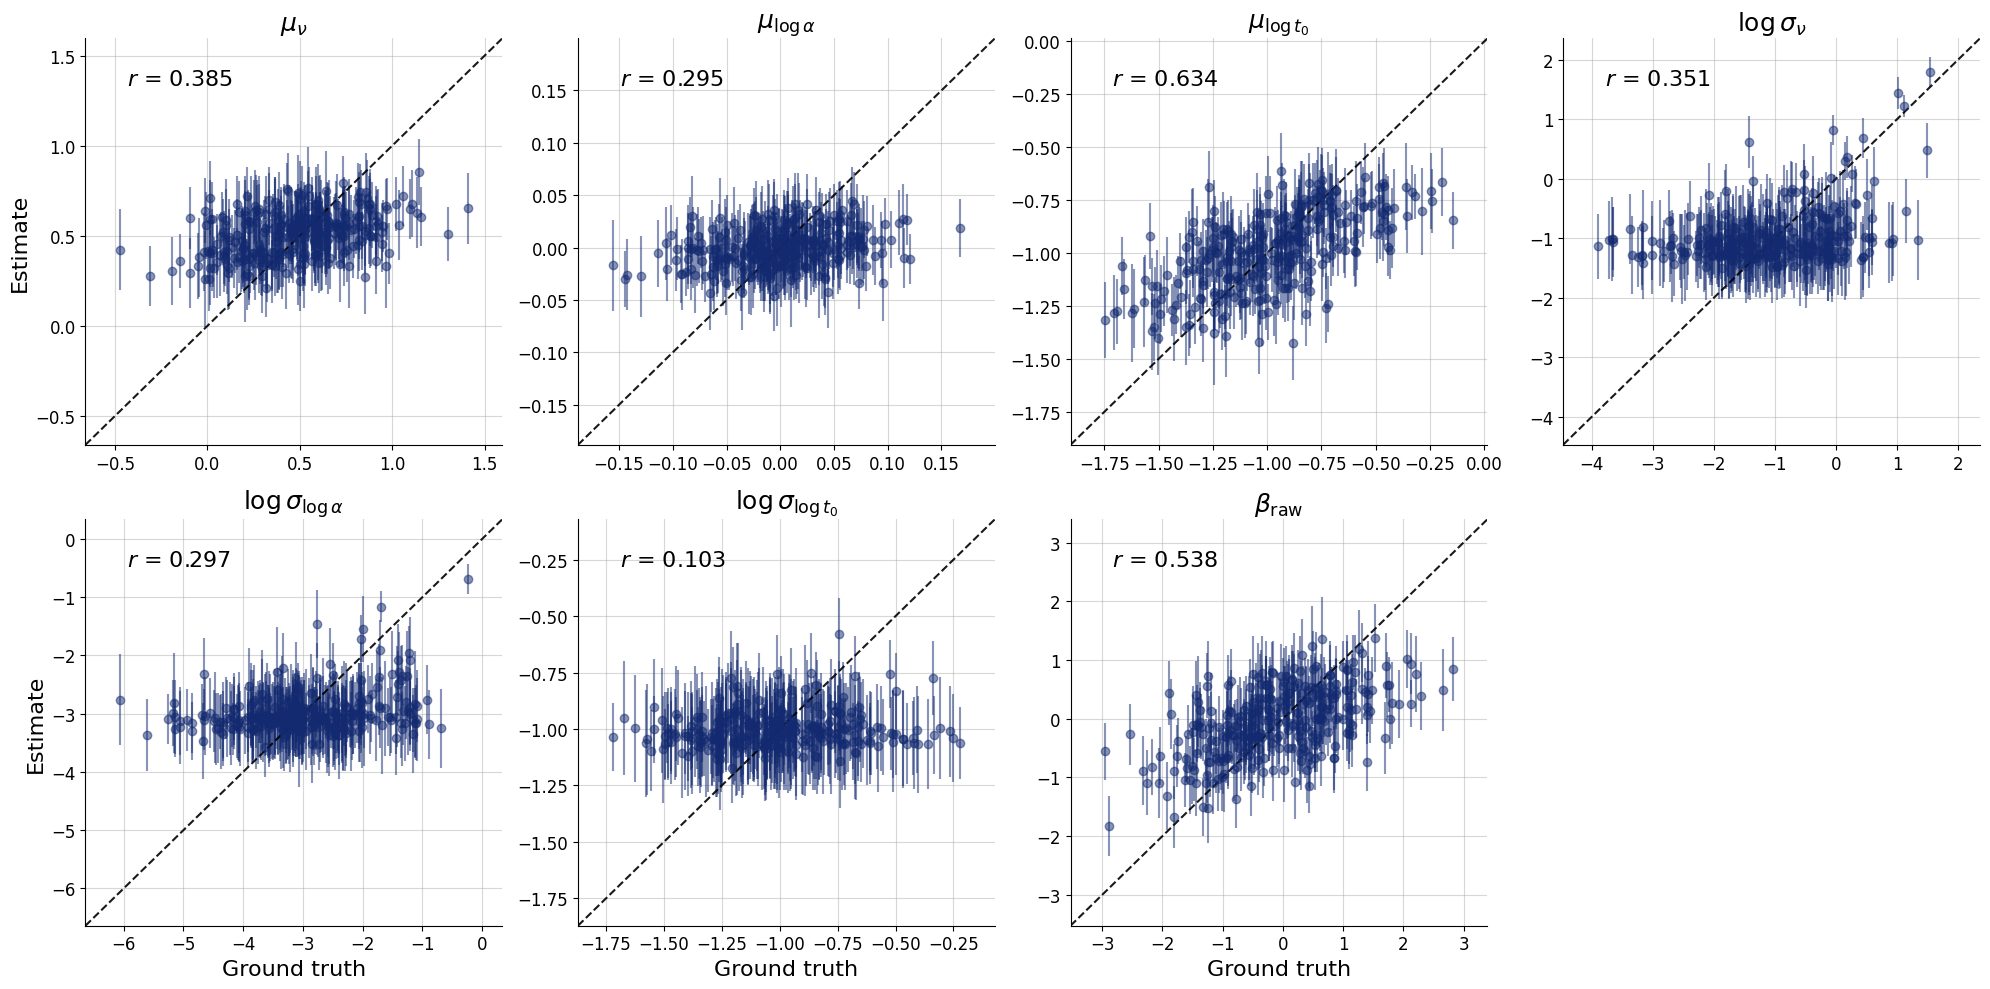

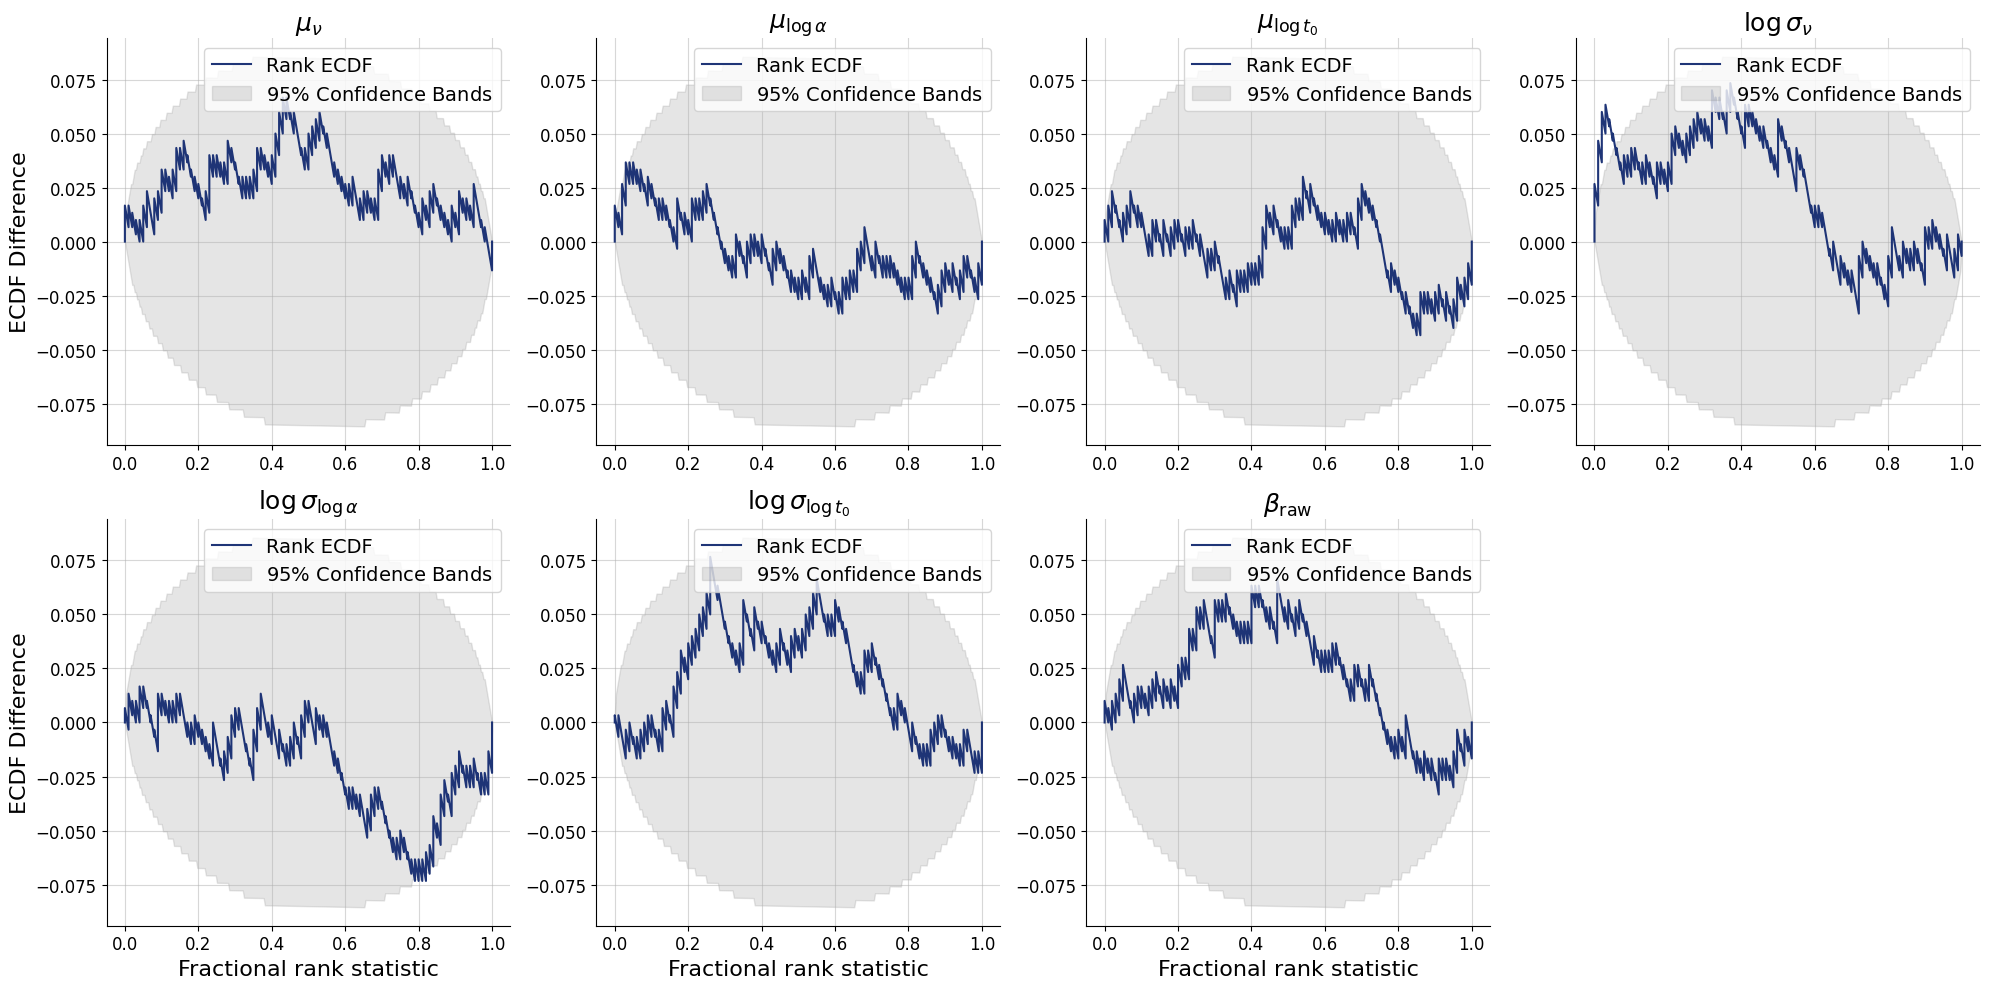

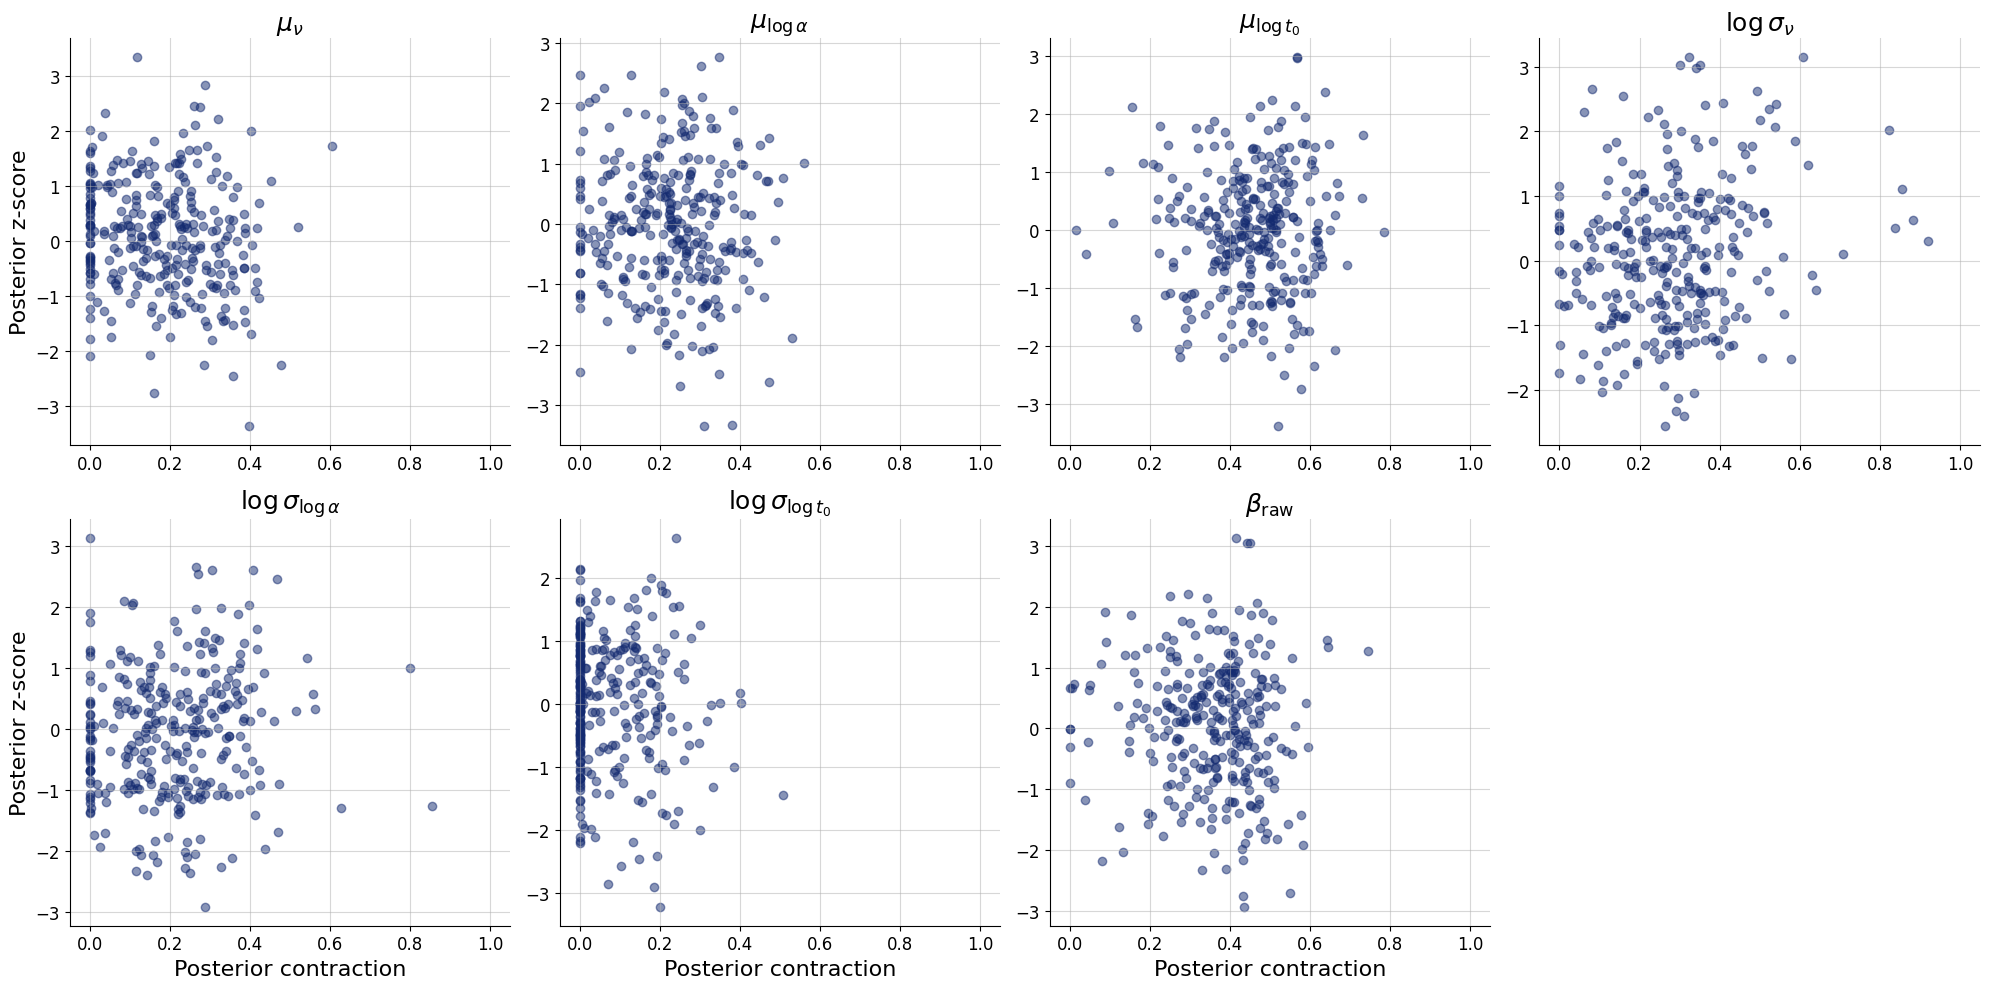

In [12]:
diagnostics_plots = workflow_global.plot_default_diagnostics(test_data=validation_data, num_samples=100,
                                                             calibration_ecdf_kwargs={"difference": True},
                                                             variable_names=pretty_param_names_global)
for k in diagnostics_plots.keys():
    diagnostics_plots[k].savefig(f"{storage}partial_pooling_single_subject_{k}.png")

# Partial Pooling: Global Compositional inference

In [13]:
test_data_comp_subjects = simulator.sample_parallel(100, n_subjects=100, n_trials=n_trials)
validation_data['sim_data'].shape, test_data_comp_subjects['sim_data'].shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
INFO:bayesflow:Using backend 'torch'
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).
INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you 

((300, 25, 2), (100, 100, 25, 2))

In [16]:
workflow_global.approximator.inference_network.integrate_kwargs = {'method': 'euler_maruyama',
                                                                   'steps': 300,
                                                                   #'corrector_steps': 3,
                                                                   #'step_size_factor': 0.01,
                                                                   'mini_batch_size': 1,
                                                                   'compositional_bridge_d1': 0.05,
                                                                   }

In [59]:
test_posterior_comp_subjects = workflow_global.compositional_sample(num_samples=100,
                                                                    conditions={'sim_data': test_data_comp_subjects['sim_data']},
                                                                    compute_prior_score=prior_score)

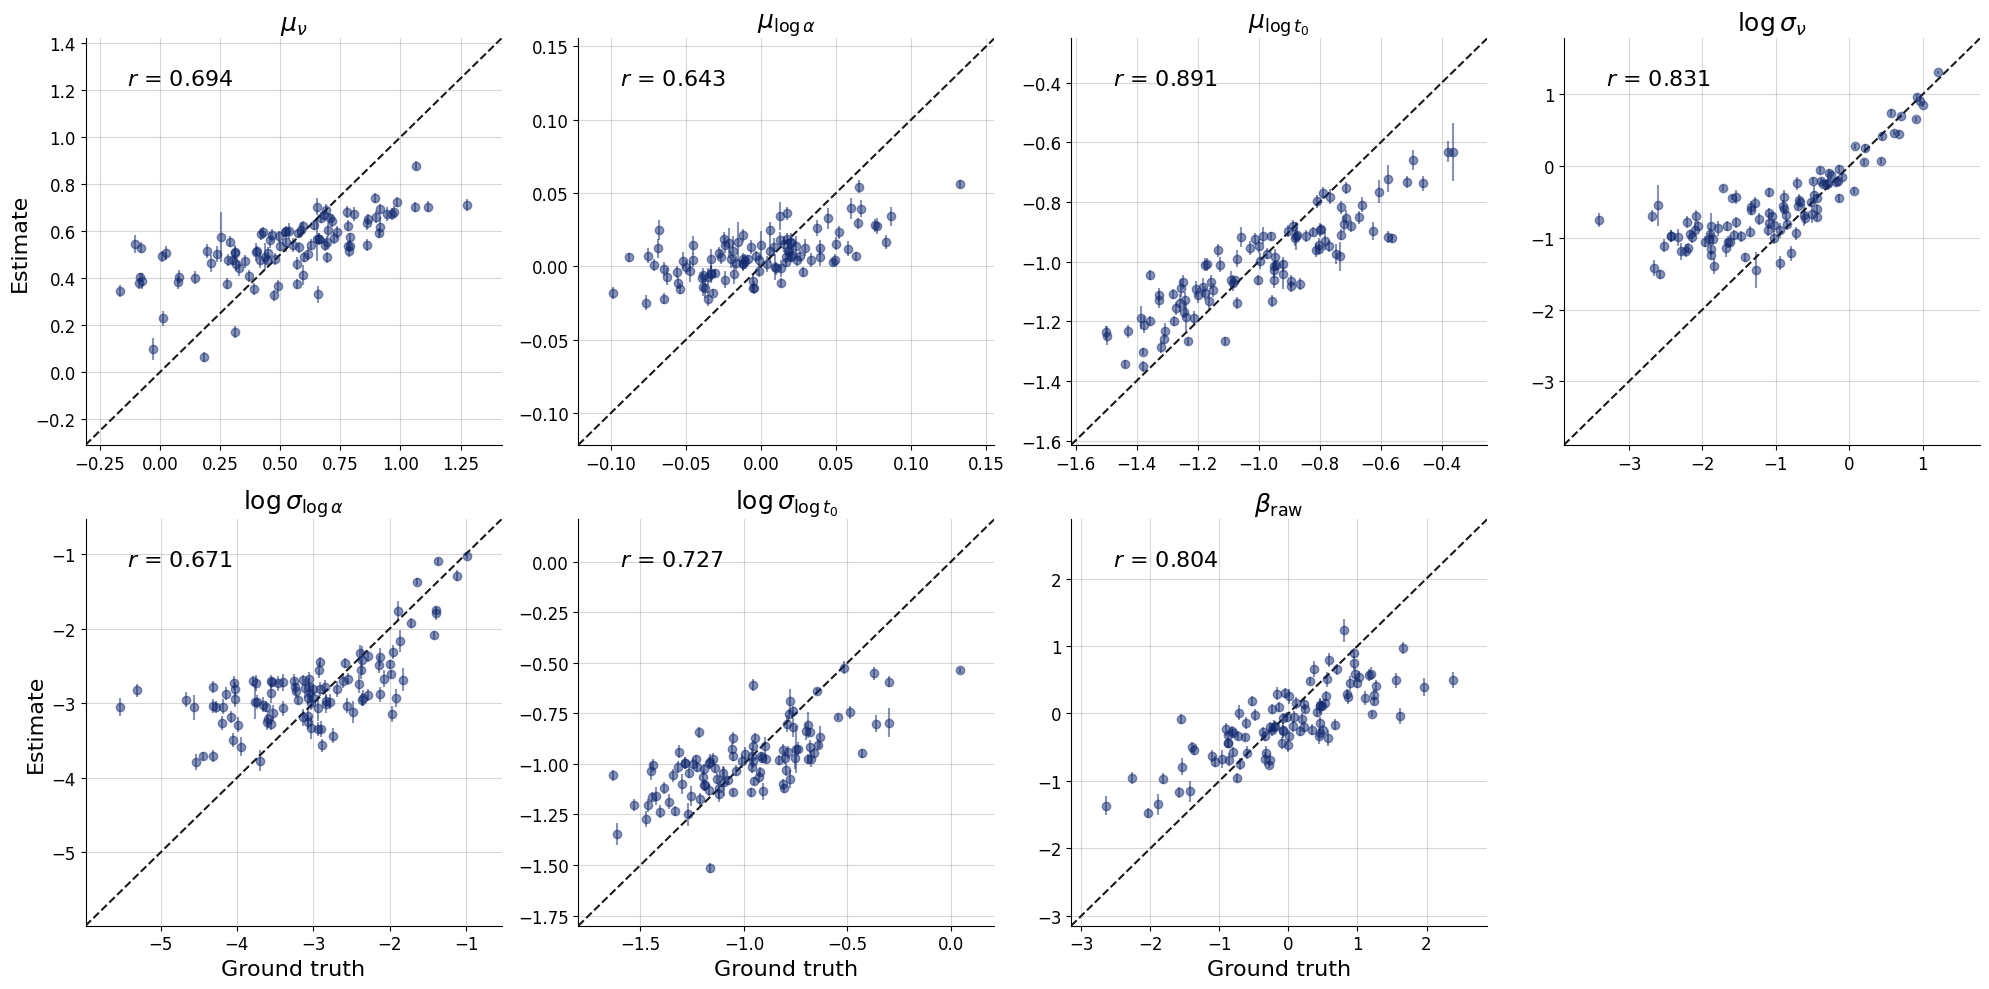

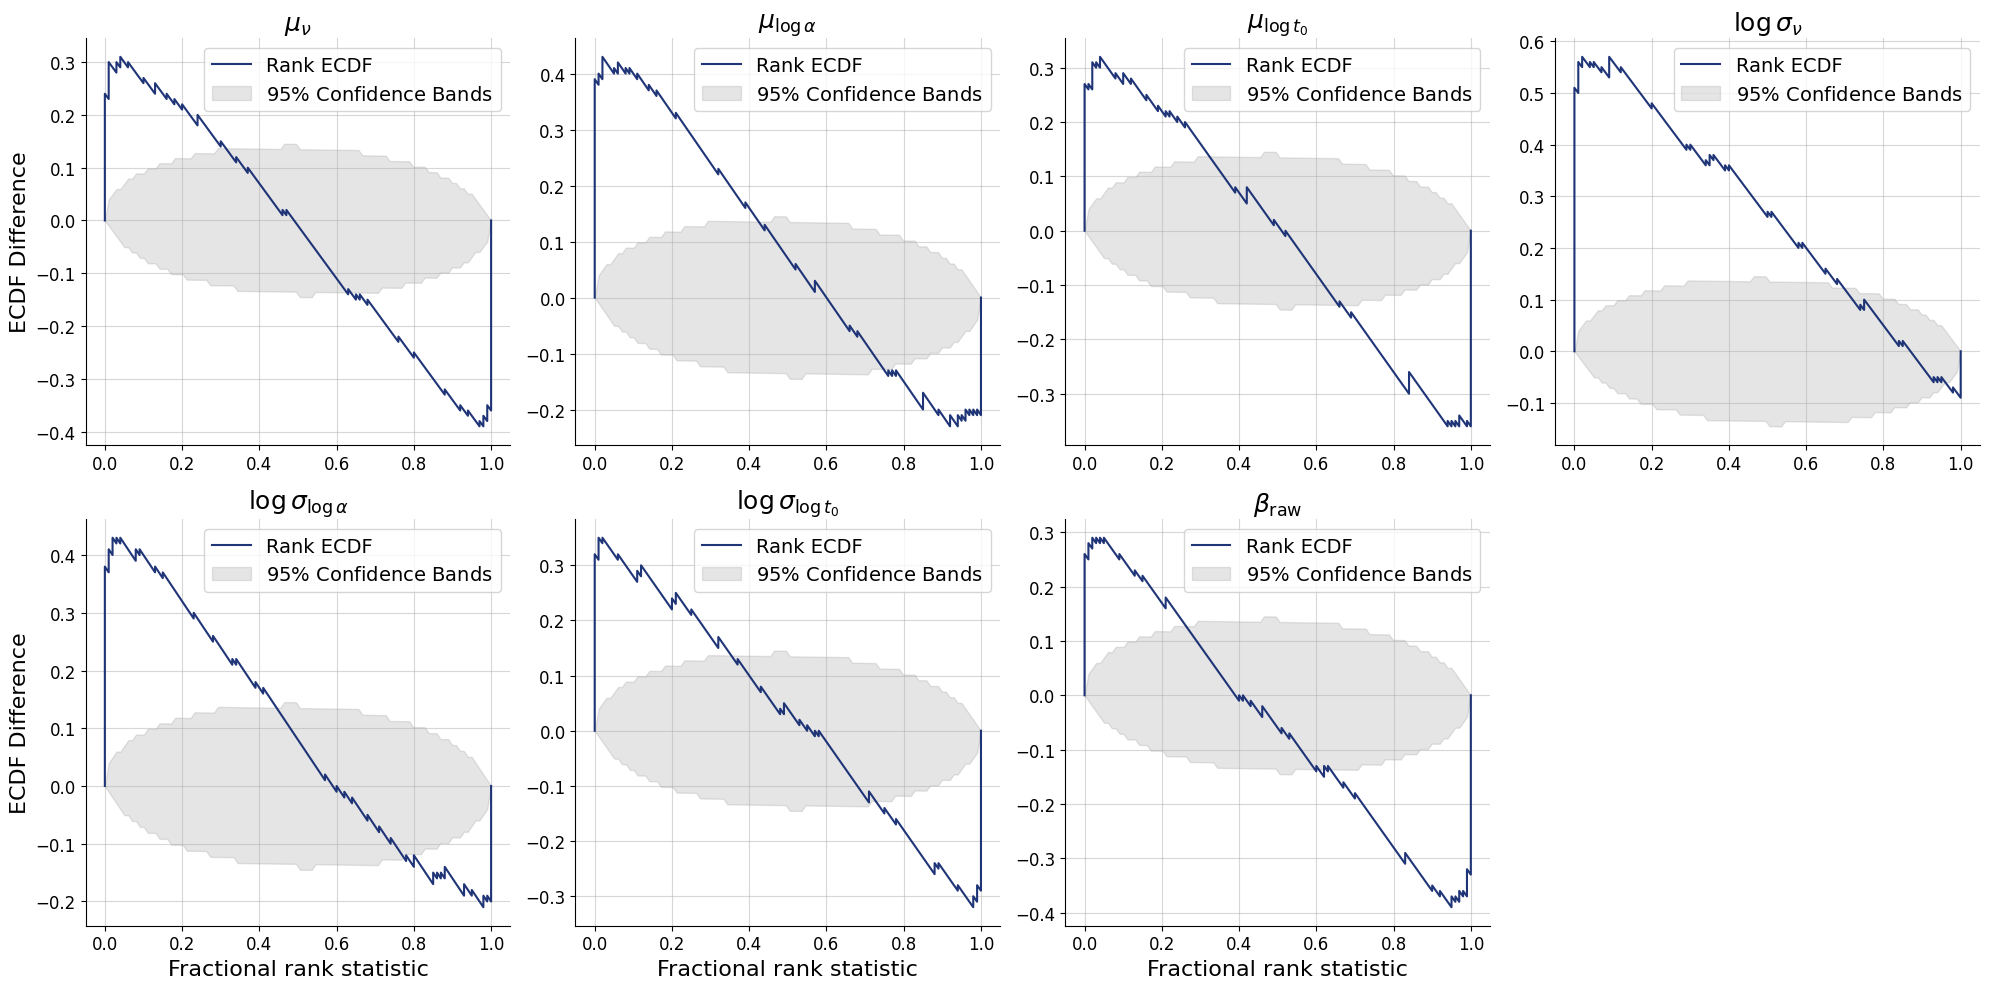

In [60]:
fig = bf.diagnostics.recovery(
    estimates=test_posterior_comp_subjects,
    targets=test_data_comp_subjects,
    variable_names=pretty_param_names_global
)
#fig.savefig(f"{storage}partial_pooling_compositional_subjects_recovery.png")

fig = bf.diagnostics.calibration_ecdf(
    estimates=test_posterior_comp_subjects,
    targets=test_data_comp_subjects,
    difference=True,
    variable_names=pretty_param_names_global
)
#fig.savefig(f"{storage}partial_pooling_compositional_subjects_calibration.png")

## Training a non-compositional local model

In [61]:
adapter_subjects = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .log(["alpha", "t0"])  # log-transform alpha and t0 to make them unbounded
    .concatenate(param_names_local, into="inference_variables")
    .concatenate(param_names_global, into="inference_conditions")
    .rename("sim_data", "summary_variables")
)

In [62]:
workflow_local = bf.BasicWorkflow(
    adapter=adapter_subjects,
    summary_network=bf.networks.SetTransformer(summary_dim=16, dropout=0.1),
    inference_network=bf.networks.FlowMatching(),
)

In [63]:
model_path = f'{storage}partial_pooling_local.keras'
if not os.path.exists(model_path):
    history = workflow_local.fit_offline(
        training_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=2,
    )
    workflow_local.approximator.save(model_path)
else:
    workflow_local.approximator = keras.models.load_model(model_path)

In [83]:
# diagnostics_plots = workflow_local.plot_default_diagnostics(test_data=validation_data, num_samples=100,
#                                                             calibration_ecdf_kwargs={"difference": True},
#                                                             variable_names=pretty_param_names_local)

In [87]:
test_data_comp_subjects['sim_data'].shape

(100, 100, 25, 2)

In [96]:
np.tile(test_data_comp_subjects['sim_data'][:, 0][..., None], 100).shape

(100, 25, 2, 100)

In [86]:
test_posterior_comp_subjects['mu_nu'].shape

(100, 100, 1)

In [147]:
# one global sample per subject
subject_id = 1
test_data_local_subject = {
    'sim_data': np.tile(test_data_comp_subjects['sim_data'][:, subject_id][..., None], 100).reshape(-1, n_trials, 2),
    'mu_nu': test_posterior_comp_subjects['mu_nu'].reshape(-1, 1),
    'mu_log_alpha': test_posterior_comp_subjects['mu_log_alpha'].reshape(-1, 1),
    'mu_log_t0': test_posterior_comp_subjects['mu_log_t0'].reshape(-1, 1),
    'log_sigma_nu': test_posterior_comp_subjects['log_sigma_nu'].reshape(-1, 1),
    'log_sigma_log_alpha': test_posterior_comp_subjects['log_sigma_log_alpha'].reshape(-1, 1),
    'log_sigma_log_t0': test_posterior_comp_subjects['log_sigma_log_t0'].reshape(-1, 1),
    'beta_raw': test_posterior_comp_subjects['beta_raw'].reshape(-1, 1),

    # true local params for evaluation
    'nu': test_data_comp_subjects['nu'][:, subject_id].reshape(-1, 1),
    'alpha': test_data_comp_subjects['alpha'][:, subject_id].reshape(-1, 1),
    't0': test_data_comp_subjects['t0'][:, subject_id].reshape(-1, 1),
}

test_local_samples_subject = workflow_local.sample(conditions=test_data_local_subject, num_samples=1)
for key in test_local_samples_subject.keys():
    test_local_samples_subject[key] = test_local_samples_subject[key].reshape(*test_posterior_comp_subjects['mu_nu'].shape)

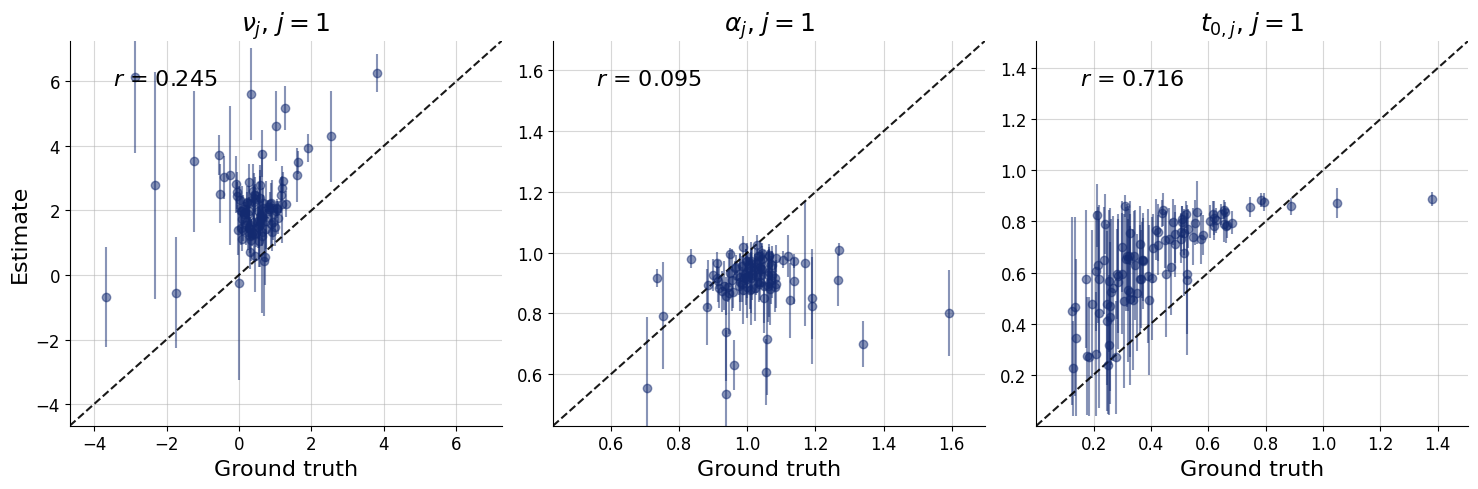

In [148]:
fig = bf.diagnostics.recovery(
    estimates=test_local_samples_subject,
    targets=test_data_local_subject,
    variable_names=[f"{p}, $j={subject_id}$" for p in pretty_param_names_local]
)

In [203]:
# one global sample per subject
dataset_id = 0
test_data_local_dataset = {
    'sim_data': np.tile(test_data_comp_subjects['sim_data'][dataset_id][..., None], 100).reshape(-1, n_trials, 2),
    'mu_nu': test_posterior_comp_subjects['mu_nu'].reshape(-1, 1),
    'mu_log_alpha': test_posterior_comp_subjects['mu_log_alpha'].reshape(-1, 1),
    'mu_log_t0': test_posterior_comp_subjects['mu_log_t0'].reshape(-1, 1),
    'log_sigma_nu': test_posterior_comp_subjects['log_sigma_nu'].reshape(-1, 1),
    'log_sigma_log_alpha': test_posterior_comp_subjects['log_sigma_log_alpha'].reshape(-1, 1),
    'log_sigma_log_t0': test_posterior_comp_subjects['log_sigma_log_t0'].reshape(-1, 1),
    'beta_raw': test_posterior_comp_subjects['beta_raw'].reshape(-1, 1),

    # true local params for evaluation
    'nu': test_data_comp_subjects['nu'][dataset_id].reshape(-1, 1),
    'alpha': test_data_comp_subjects['alpha'][dataset_id].reshape(-1, 1),
    't0': test_data_comp_subjects['t0'][dataset_id].reshape(-1, 1),
}

test_local_samples_dataset = workflow_local.sample(conditions=test_data_local_dataset, num_samples=1)

In [204]:
for key in test_local_samples_dataset.keys():
    test_local_samples_dataset[key] = test_local_samples_dataset[key].reshape(*test_posterior_comp_subjects['mu_nu'].shape)

posterior_global_medians = {k: np.median(v, axis=1) for k, v in test_posterior_comp_subjects.items()}
posterior_global_medians['nu'] =  np.tile(posterior_global_medians['mu_nu'][dataset_id], 100)
posterior_global_medians['alpha'] =  np.tile(np.exp(posterior_global_medians['mu_log_alpha'])[dataset_id], 100)
posterior_global_medians['t0'] = np.tile(np.exp(posterior_global_medians['mu_log_t0'])[dataset_id], 100)

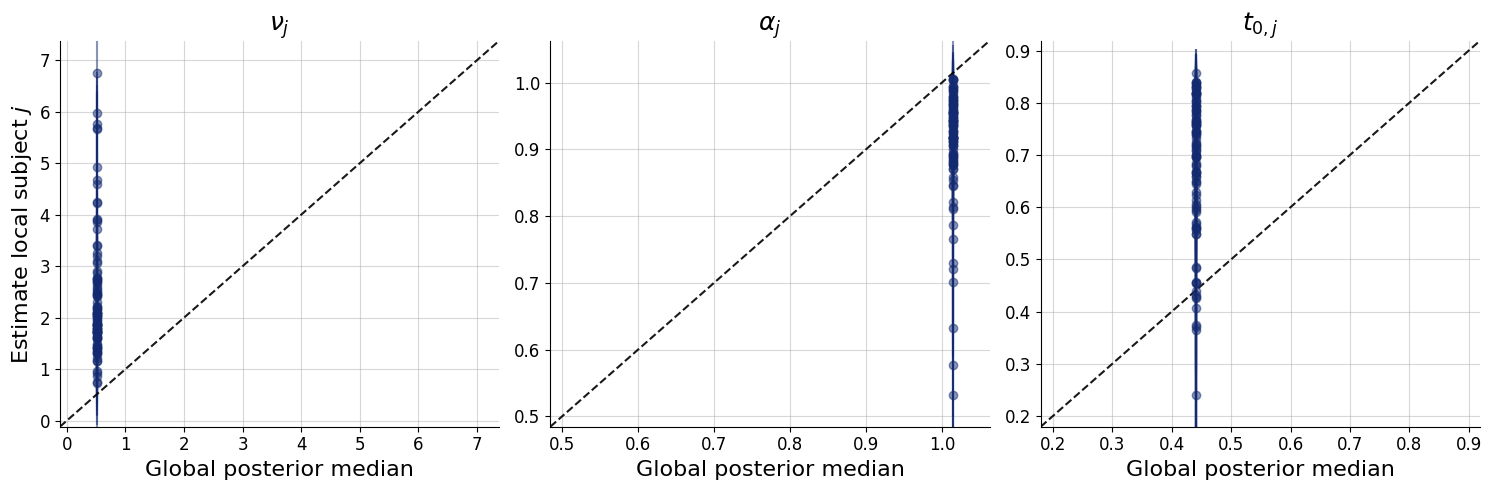

In [205]:
fig = bf.diagnostics.recovery(
    estimates=test_local_samples_dataset,
    targets=posterior_global_medians,
    xlabel='Global posterior median',
    ylabel="Estimate local subject $j$",
    variable_names=pretty_param_names_local,
    add_corr=False
)

In [206]:
posterior_global_dataset = {k: v[dataset_id] for k, v in test_posterior_comp_subjects.items()}
posterior_global_dataset['nu'] = np.random.normal(posterior_global_dataset['mu_nu'],
                                                  np.exp(posterior_global_dataset['log_sigma_nu']))
posterior_global_dataset['alpha'] = np.random.lognormal(posterior_global_dataset['mu_log_alpha'],
                                                        np.exp(posterior_global_dataset['log_sigma_log_alpha']))
posterior_global_dataset['t0'] = np.random.lognormal(posterior_global_dataset['mu_log_t0'],
                                                     np.exp(posterior_global_dataset['log_sigma_log_t0']))

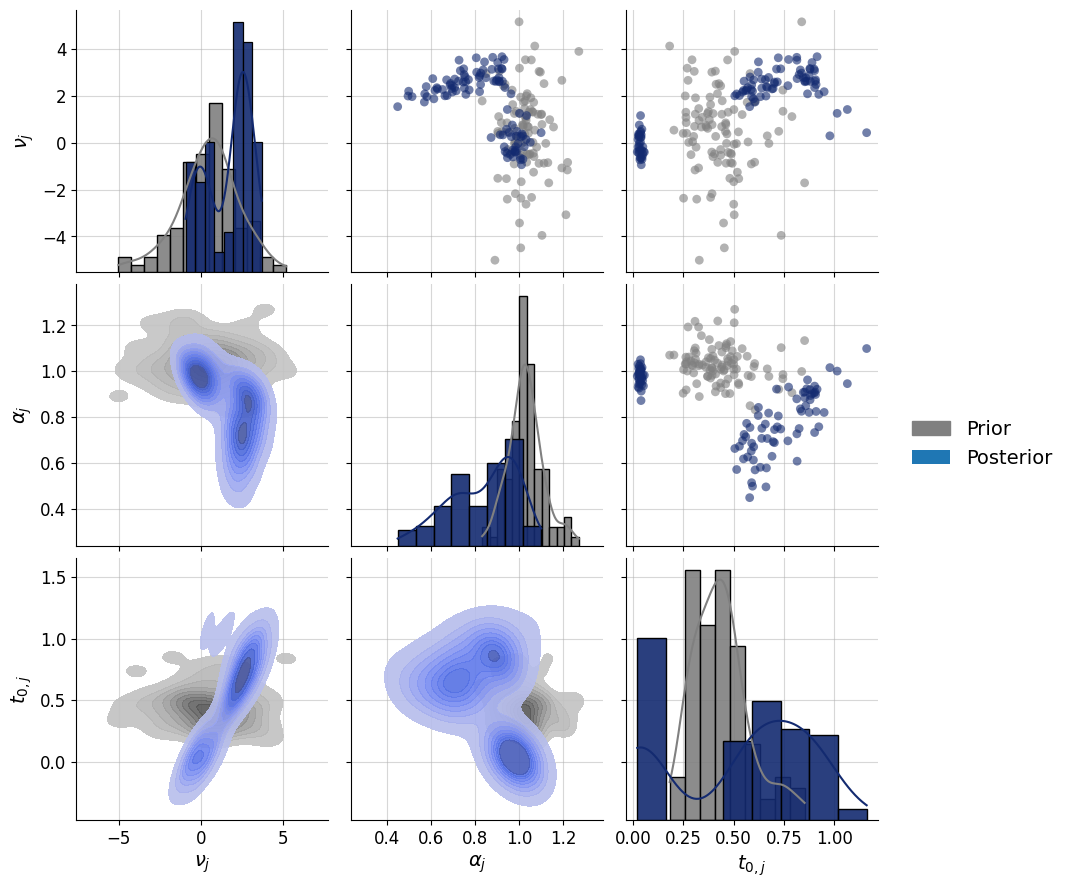

In [208]:
fig = bf.diagnostics.pairs_posterior(
    estimates=test_local_samples_dataset,
    priors=posterior_global_dataset,
    dataset_id=1,  # subject id in the dataset
    variable_names=pretty_param_names_local,
)